In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [3]:
# Load the dataset
file_path = "C:\\Users\\nihar\\OneDrive\\Desktop\\Bootcamp\\SCMA 632\\DataSet\\pinksheet.xlsx"
monthly_prices_df = pd.read_excel(file_path, sheet_name='Monthly Prices', skiprows=6)

In [5]:
# Print data types to verify correct loading
print(monthly_prices_df.dtypes)

Unnamed: 0      object
CRUDE_PETRO    float64
CRUDE_BRENT    float64
CRUDE_DUBAI    float64
CRUDE_WTI       object
                ...   
NICKEL         float64
Zinc           float64
GOLD           float64
PLATINUM       float64
SILVER         float64
Length: 72, dtype: object


In [7]:
# Rename 'Unnamed: 0' to 'Date' and convert date format
monthly_prices_df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
monthly_prices_df['Date'] = pd.to_datetime(monthly_prices_df['Date'], format='%YM%m').dt.strftime('%Y-%m-%d')

In [9]:
# Print data types to verify correct loading
print(monthly_prices_df.dtypes)

Date            object
CRUDE_PETRO    float64
CRUDE_BRENT    float64
CRUDE_DUBAI    float64
CRUDE_WTI       object
                ...   
NICKEL         float64
Zinc           float64
GOLD           float64
PLATINUM       float64
SILVER         float64
Length: 72, dtype: object


In [15]:
# Extract the date column and the gold price column
gold_prices_df = monthly_prices_df.loc[:, ['Date', 'GOLD']].dropna().copy()
gold_prices_df.columns = ['Date', 'Gold_Price']

In [19]:
# Convert the Date column to datetime format
gold_prices_df['Date'] = pd.to_datetime(gold_prices_df['Date'])

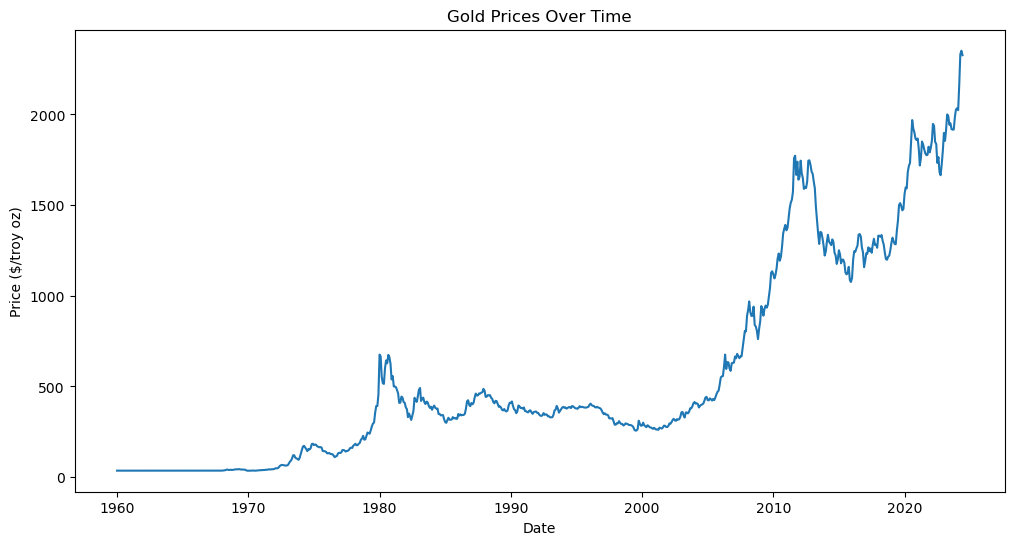

In [21]:
# Step 2: EDA
plt.figure(figsize=(12, 6))
plt.plot(gold_prices_df['Date'], gold_prices_df['Gold_Price'])
plt.title('Gold Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($/troy oz)')
plt.show()

In [25]:
# Visualize the rolling mean and standard deviation
rolling_mean = gold_prices_df['Gold_Price'].rolling(window=12).mean()
rolling_std = gold_prices_df['Gold_Price'].rolling(window=12).std()

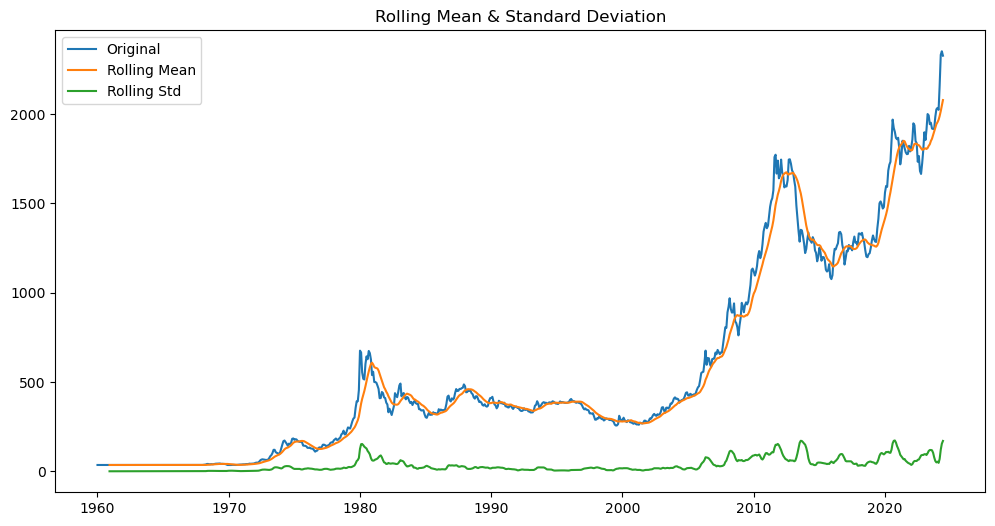

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(gold_prices_df['Date'], gold_prices_df['Gold_Price'], label='Original')
plt.plot(gold_prices_df['Date'], rolling_mean, label='Rolling Mean')
plt.plot(gold_prices_df['Date'], rolling_std, label='Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

In [29]:
# Step 3: Modeling
# Split the data into training and test sets
train_size = int(len(gold_prices_df) * 0.8)
train, test = gold_prices_df.iloc[:train_size], gold_prices_df.iloc[train_size:]

In [33]:
# Ensure the necessary package is imported
from statsmodels.tsa.arima.model import ARIMA

C:\Users\nihar\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


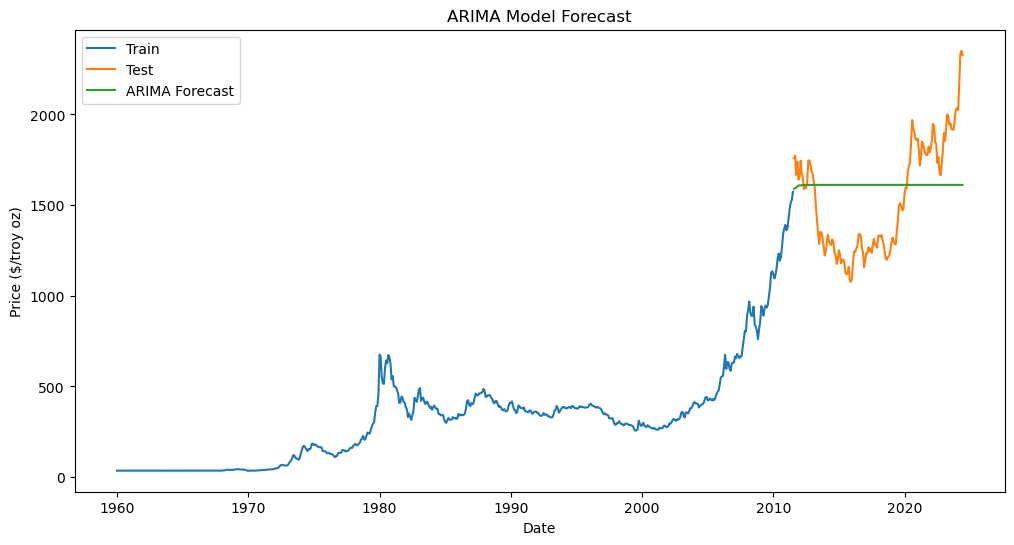

In [35]:
# ARIMA Model
arima_model = ARIMA(train['Gold_Price'], order=(5, 1, 0))
arima_result = arima_model.fit()
arima_forecast = arima_result.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')

plt.figure(figsize=(12, 6))
plt.plot(train['Date'], train['Gold_Price'], label='Train')
plt.plot(test['Date'], test['Gold_Price'], label='Test')
plt.plot(test['Date'], arima_forecast, label='ARIMA Forecast')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($/troy oz)')
plt.legend()
plt.show()

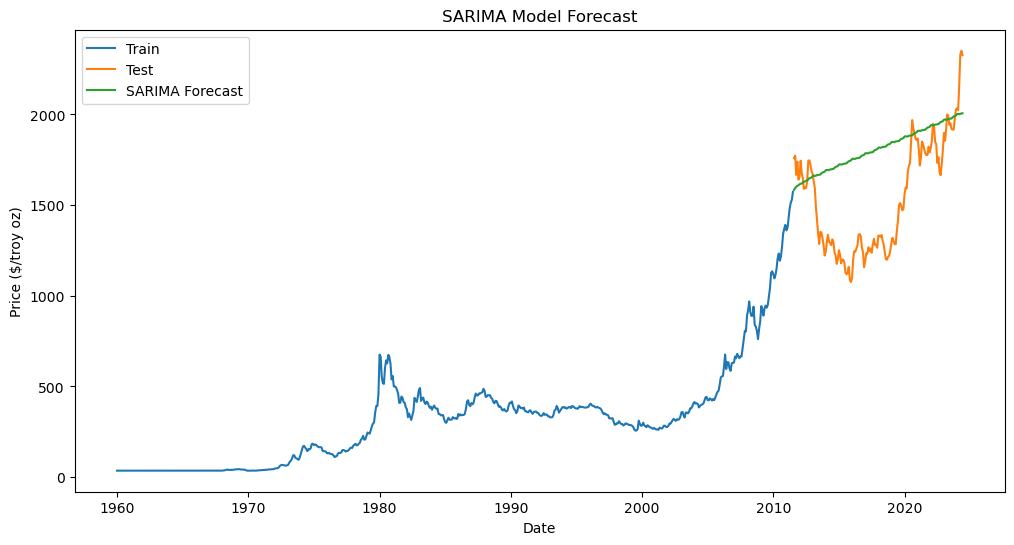

In [37]:
# SARIMA Model
sarima_model = SARIMAX(train['Gold_Price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit(disp=False)
sarima_forecast = sarima_result.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

plt.figure(figsize=(12, 6))
plt.plot(train['Date'], train['Gold_Price'], label='Train')
plt.plot(test['Date'], test['Gold_Price'], label='Test')
plt.plot(test['Date'], sarima_forecast, label='SARIMA Forecast')
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($/troy oz)')
plt.legend()
plt.show()

In [43]:
from keras.layers import Input

In [45]:
# LSTM Model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[['Gold_Price']])

X_train = []
y_train = []
for i in range(60, len(scaled_train)):
    X_train.append(scaled_train[i-60:i, 0])
    y_train.append(scaled_train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(LSTM(units=50, return_sequences=False))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=1, batch_size=1)

559/559 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 0.0055


In [47]:
# Prepare test data for LSTM
scaled_test = scaler.transform(test[['Gold_Price']])
X_test = []
for i in range(60, len(scaled_test)):
    X_test.append(scaled_test[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [49]:
lstm_forecast = lstm_model.predict(X_test)
lstm_forecast = scaler.inverse_transform(lstm_forecast)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 415ms/step


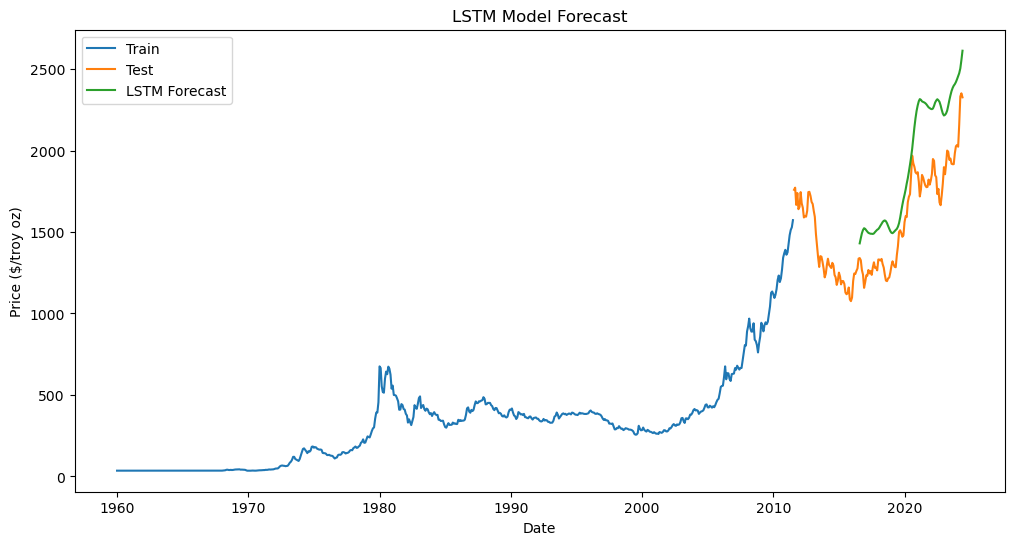

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(train['Date'], train['Gold_Price'], label='Train')
plt.plot(test['Date'], test['Gold_Price'], label='Test')
plt.plot(test['Date'][60:], lstm_forecast, label='LSTM Forecast')
plt.title('LSTM Model Forecast')
plt.xlabel('Date')
plt.ylabel('Price ($/troy oz)')
plt.legend()
plt.show()

In [53]:
# Step 4: Evaluation and Interpretation
arima_rmse = np.sqrt(mean_squared_error(test['Gold_Price'], arima_forecast))
arima_mape = mean_absolute_percentage_error(test['Gold_Price'], arima_forecast)
arima_mae = mean_absolute_error(test['Gold_Price'], arima_forecast)

sarima_rmse = np.sqrt(mean_squared_error(test['Gold_Price'], sarima_forecast))
sarima_mape = mean_absolute_percentage_error(test['Gold_Price'], sarima_forecast)
sarima_mae = mean_absolute_error(test['Gold_Price'], sarima_forecast)

lstm_rmse = np.sqrt(mean_squared_error(test['Gold_Price'][60:], lstm_forecast))
lstm_mape = mean_absolute_percentage_error(test['Gold_Price'][60:], lstm_forecast)
lstm_mae = mean_absolute_error(test['Gold_Price'][60:], lstm_forecast)

In [55]:
print(f'ARIMA RMSE: {arima_rmse}, MAPE: {arima_mape}, MAE: {arima_mae}')
print(f'SARIMA RMSE: {sarima_rmse}, MAPE: {sarima_mape}, MAE: {sarima_mae}')
print(f'LSTM RMSE: {lstm_rmse}, MAPE: {lstm_mape}, MAE: {lstm_mae}')

ARIMA RMSE: 312.46254770020676, MAPE: 0.194134109622934, MAE: 277.2123939518533
SARIMA RMSE: 375.3057210959555, MAPE: 0.23375858876755568, MAE: 308.7535917515804
LSTM RMSE: 339.1783670729589, MAPE: 0.1916786300326683, MAE: 310.00291123560856


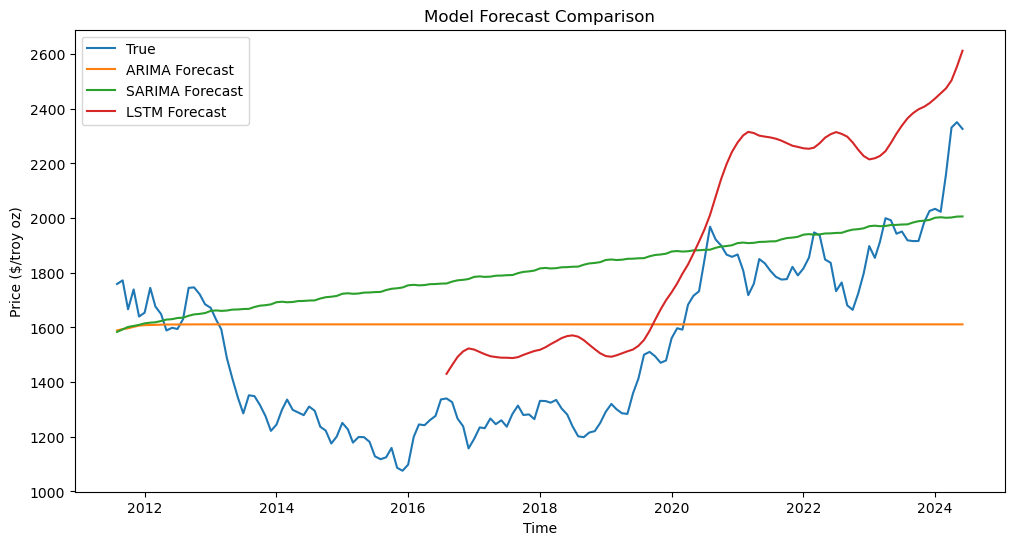

In [57]:
# Plot comparison of all forecasts
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], test['Gold_Price'].values, label='True')
plt.plot(test['Date'], arima_forecast.values, label='ARIMA Forecast')
plt.plot(test['Date'], sarima_forecast.values, label='SARIMA Forecast')
plt.plot(test['Date'][60:], lstm_forecast, label='LSTM Forecast')
plt.title('Model Forecast Comparison')
plt.xlabel('Time')
plt.ylabel('Price ($/troy oz)')
plt.legend()
plt.show()

In [59]:
# Interpretation of Results
best_model = min((arima_rmse, 'ARIMA'), (sarima_rmse, 'SARIMA'), (lstm_rmse, 'LSTM'))[1]

print(f'The best model is: {best_model}')

The best model is: ARIMA
